In [1]:
# !pip install oolearning --upgrade

In [2]:
import copy
import os
import oolearning as oo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from helpers import column_log, BinaryAucRocScore

pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
width = 10
plt.rcParams['figure.figsize'] = [width, width/1.333]

In [3]:
csv_file = '../census.csv'
target_variable = 'income'

explore = oo.ExploreClassificationDataset.from_csv(csv_file_path=csv_file,
                                                   target_variable=target_variable)
negative_class = '<=50K'
positive_class = '>50K'

explore.dataset.head(20)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
5,37,Private,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K
6,49,Private,9th,5.0,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica,<=50K
7,52,Self-emp-not-inc,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,>50K
8,31,Private,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,>50K
9,42,Private,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,>50K


In [4]:
global_transformations = [oo.ImputationTransformer(),
                          oo.StatelessColumnTransformer(columns=['capital-gain', 'capital-loss'],
                                                        custom_function=column_log),
                          oo.CenterScaleTransformer(),
                          oo.DummyEncodeTransformer(oo.CategoricalEncoding.ONE_HOT)]

In [5]:
params_dict = dict(
                    min_child_weight=[3, 4, 5],
                    max_depth=[3, 4],
                    n_estimators=[100, 500, 1000],
)
grid = oo.HyperParamsGrid(params_dict=params_dict)
grid.params_grid

,min_child_weight,max_depth,n_estimators
0,3,3,100
1,3,3,500
2,3,3,1000
3,3,4,100
4,3,4,500
5,3,4,1000
6,4,3,100
7,4,3,500
8,4,3,1000
9,4,4,100


In [6]:
n_positive = np.sum(explore.dataset[target_variable] == positive_class)
n_negative = np.sum(explore.dataset.income == negative_class)
scale_pos_weight_calc = n_negative / n_positive
scale_pos_weight_calc

3.034796573875803

In [7]:
hyper_param_object = oo.XGBoostTreeHP(
                                objective=oo.XGBObjective.BINARY_LOGISTIC,
                                learning_rate=0.3,
                                n_estimators=1000,
                                max_depth=4,
                                min_child_weight=3,
                                gamma=0.1,
                                subsample=0.8,
                                colsample_bytree=0.8,
                                scale_pos_weight=scale_pos_weight_calc,)

In [8]:
model=oo.XGBoostClassifier()

In [9]:
repeats = 5
folds = 5

In [10]:
model_cache_directory = 'tuner_XGB'
resampler_cache_directory = 'tuner_XGB_resample_cache'

In [11]:
score_list = [BinaryAucRocScore(positive_class=positive_class, threshold=0.5),
              oo.AucRocScore(positive_class=positive_class),
              oo.FBetaScore(converter=oo.TwoClassThresholdConverter(threshold=0.5,
                                                                    positive_class=positive_class),
                            beta=0.5),
              oo.SensitivityScore(converter=oo.TwoClassThresholdConverter(threshold=0.5,
                                                                          positive_class=positive_class)),
              oo.PositivePredictiveValueScore(converter=oo.TwoClassThresholdConverter(threshold=0.5,
                                                                                      positive_class=positive_class))]

In [12]:

# define/configure the resampler
resampler = oo.RepeatedCrossValidationResampler(model=model,  # using a Random Forest model
                                             transformations=global_transformations,
                                             scores=[s.clone() for s in score_list],
                                             folds=folds,
                                             repeats=repeats)
# define/configure the ModelTuner
tuner = oo.ModelTuner(resampler=resampler,
                      hyper_param_object=hyper_param_object,
                      model_persistence_manager=oo.LocalCacheManager(cache_directory=model_cache_directory),
                      resampler_persistence_manager=oo.LocalCacheManager(cache_directory=resampler_cache_directory),
                      parallelization_cores=-1,  # Hyper-Parameter object specific to RF
                      #parallelization_cores=0,
                     )

In [13]:
tuner.tune(data_x=explore.dataset.drop(columns=target_variable),
           data_y=explore.dataset[target_variable],
           params_grid=grid)

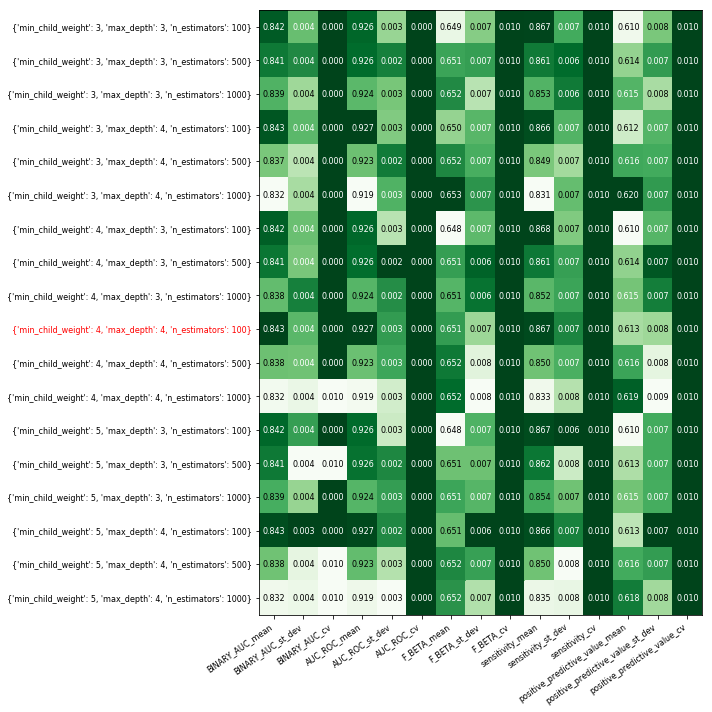

In [14]:
tuner.results.plot_resampled_stats()

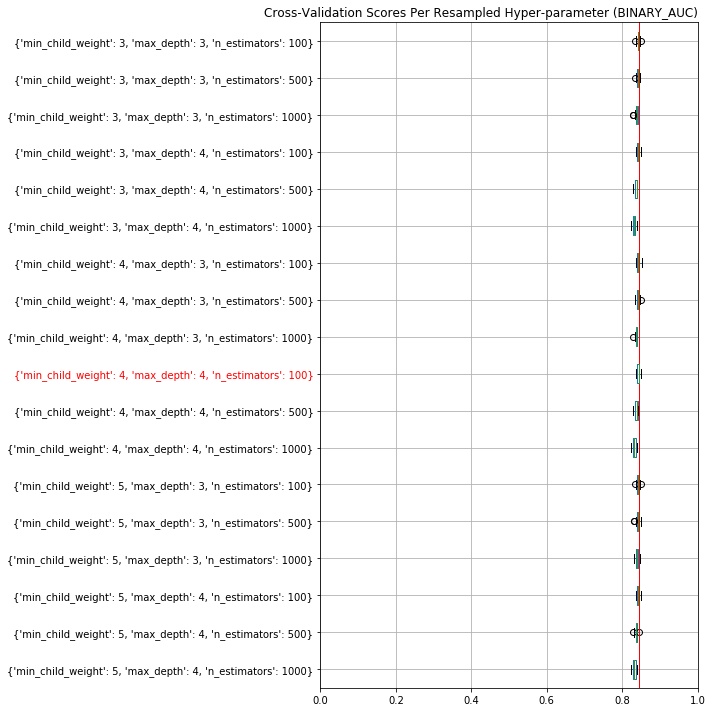

In [15]:
tuner.results.plot_resampled_scores(score_name='BINARY_AUC')

Try

```
min_child_weight: [3, 4, 5],
max_depth: [3, 4],
gamma: [0.1],
n_estimators: [100, 500, 1000],
subsample: [TBD],
colsample_bytree: [TBD],
```

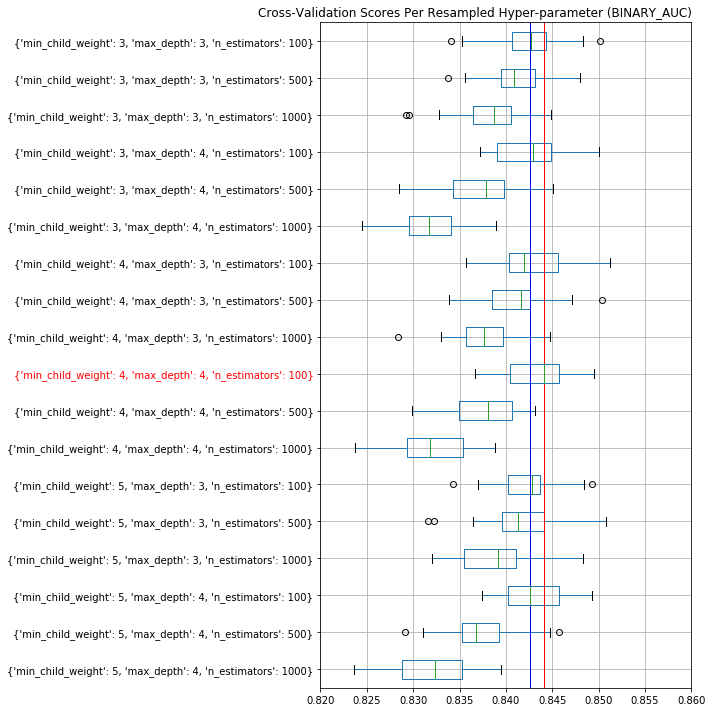

In [18]:
tuner.results.plot_resampled_scores(score_name='BINARY_AUC',
                                    x_axis_limits=(0.82, 0.86),
                                    show_one_ste_rule=True
                                   )

In [25]:
final_hyper_param_object = oo.XGBoostTreeHP(
                                    objective=oo.XGBObjective.BINARY_LOGISTIC,
                                    learning_rate=0.3,
                                    n_estimators=1000,
                                    max_depth=4,
                                    min_child_weight=3,
                                    gamma=0.1,
                                    subsample=0.8,
                                    colsample_bytree=0.8,
                                    scale_pos_weight=scale_pos_weight_calc,)

final_model = oo.XGBoostClassifier()
final_transformations = [
                         # kaggle test file has white space around values
                         oo.StatelessColumnTransformer(columns=explore.categoric_features,
                                                       custom_function=lambda x: x.str.strip()),
                         oo.ImputationTransformer(),
                         oo.StatelessColumnTransformer(columns=['capital-gain', 'capital-loss'],
                                                       custom_function=column_log),
                         oo.CenterScaleTransformer(),
                         oo.DummyEncodeTransformer(oo.CategoricalEncoding.ONE_HOT)
]

# Resample Ideal Threshold

In [27]:
decorator = oo.TwoClassThresholdDecorator(parallelization_cores=0)
resampler = oo.RepeatedCrossValidationResampler(
    model=final_model.clonbe(),
    transformations=[t.clone() for t in final_transformations],
    scores=[s.clone() for s in score_list],
    folds=5,  # 5 folds with 5 repeats
    repeats=1,
    fold_decorators=[decorator])
resampler.resample(data_x=explore.dataset.drop(columns=target_variable),
                   data_y=explore.dataset[target_variable],
                   hyper_params=final_hyper_param_object.clone())
ideal_threshold = np.mean(decorator.roc_ideal_thresholds)

In [32]:
ideal_threshold

0.488

In [37]:
# use the ideal threshold for the evaluator in order to view ROC
evaluator = oo.TwoClassProbabilityEvaluator(converter=
                    oo.TwoClassThresholdConverter(threshold=ideal_threshold,  # ideal threshold
                                                  positive_class=positive_class))

trainer = oo.ModelTrainer(model=final_model.clone(),
                          model_transformations=[t.clone() for t in final_transformations],
                          splitter=None,  # don't split, train on all data
                          evaluator=evaluator,
                          scores=[s.clone() for s in score_list])
trainer.train(data=explore.dataset, target_variable=target_variable, hyper_params=final_hyper_param_object.clone())

trainer.training_evaluator.all_quality_metrics

{'AUC ROC': 0.9607996153240339,
 'AUC Precision/Recall': 0.8937558945360837,
 'Kappa': 0.6921023804586903,
 'F1 Score': 0.7807886376378247,
 'Two-Class Accuracy': 0.8703064879925699,
 'Error Rate': 0.12969351200743,
 'True Positive Rate': 0.9319236259814418,
 'True Negative Rate': 0.8500029399658964,
 'False Positive Rate': 0.1499970600341036,
 'False Negative Rate': 0.06807637401855818,
 'Positive Predictive Value': 0.6718337943011513,
 'Negative Predictive Value': 0.9742881213142376,
 'Prevalence': 0.2478439697492371,
 'No Information Rate': 0.7521560302507629,
 'Total Observations': 45222}

In [43]:
trainer.training_scores[0]

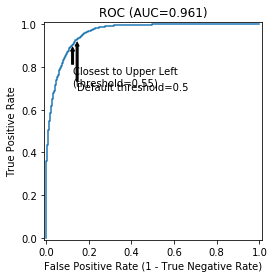

In [38]:
trainer.training_evaluator.plot_roc_curve()

In [44]:
csv_file = '../test_census.csv'
test_dataset = pd.read_csv(csv_file)
test_dataset.shape

(45222, 14)

In [45]:
test_dataset.head(10)

,Unnamed: 0,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0,21.0,Private,10th,6.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40.0,United-States
1,1,49.0,Private,Bachelors,13.0,Married-civ-spouse,Adm-clerical,Wife,White,Female,0.0,0.0,40.0,United-States
2,2,44.0,Self-emp-not-inc,Assoc-acdm,12.0,Married-civ-spouse,Other-service,Wife,White,Female,0.0,0.0,99.0,United-States
3,3,34.0,Private,Bachelors,13.0,Married-civ-spouse,Sales,Husband,White,Male,7298.0,0.0,46.0,United-States
4,4,24.0,Private,HS-grad,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States
5,5,52.0,Private,7th-8th,4.0,Divorced,Priv-house-serv,Own-child,Black,Female,0.0,0.0,16.0,United-States
6,6,61.0,Private,7th-8th,4.0,Married-civ-spouse,Transport-moving,Husband,White,Male,0.0,0.0,50.0,United-States
7,7,24.0,Private,HS-grad,9.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40.0,United-States
8,8,30.0,Private,HS-grad,9.0,Never-married,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,22.0,United-States
9,9,42.0,Local-gov,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States


In [60]:
indexes = test_dataset['Unnamed: 0']

predictions = trainer.predict(test_dataset.drop(columns='Unnamed: 0'))
test_converter = oo.TwoClassThresholdConverter(threshold=ideal_threshold,  # ideal thresholds
                                               positive_class=positive_class)
predictions.head()

,<=50K,>50K
0,0.998511,0.001489
1,0.073834,0.926166
2,0.969710,0.030290
3,0.000102,0.999898
4,0.953209,0.046791


In [62]:
class_predictions = test_converter.convert(predictions)
class_predictions[0:5]

array(['<=50K', '>50K', '<=50K', '>50K', '<=50K'], dtype='<U5')

In [64]:
income_value = [0 if x == '<=50K' else 1 for x in class_predictions]
pd.DataFrame({'id': indexes, 'income': income_value}).to_csv('submission_4_xgb.csv',
                                                             index=False)
